In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os

In [3]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-09-07 17:25:49.435536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [4]:
adata = sc.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [5]:
adata_atac = adata.copy()
adata_rna = adata.copy()

In [6]:
adata_atac

AnnData object with n_obs × n_vars = 16918 × 242922
    obs: 'n_counts', 'sample', 'n_genes', 'log_genes', 'mt_frac', 'rp_frac', 'ambi_frac', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'S_score', 'G2M_score', 'phase', 'proliferation', 'celltype', 'nCount_peaks', 'nFeature_peaks'
    var: 'modality'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_pca_wsnn', 'X_spca_wsnn', 'X_umap', 'X_umap_ATAC', 'X_umap_GEX', 'X_umap_wsnn', 'lsi_full', 'lsi_red', 'umap', 'umap_ATAC', 'umap_GEX'
    obsp: 'connectivities', 'connectivities_wnn', 'distances', 'distances_wnn'

In [7]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["lsi_red"], norm="l2"
)



/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


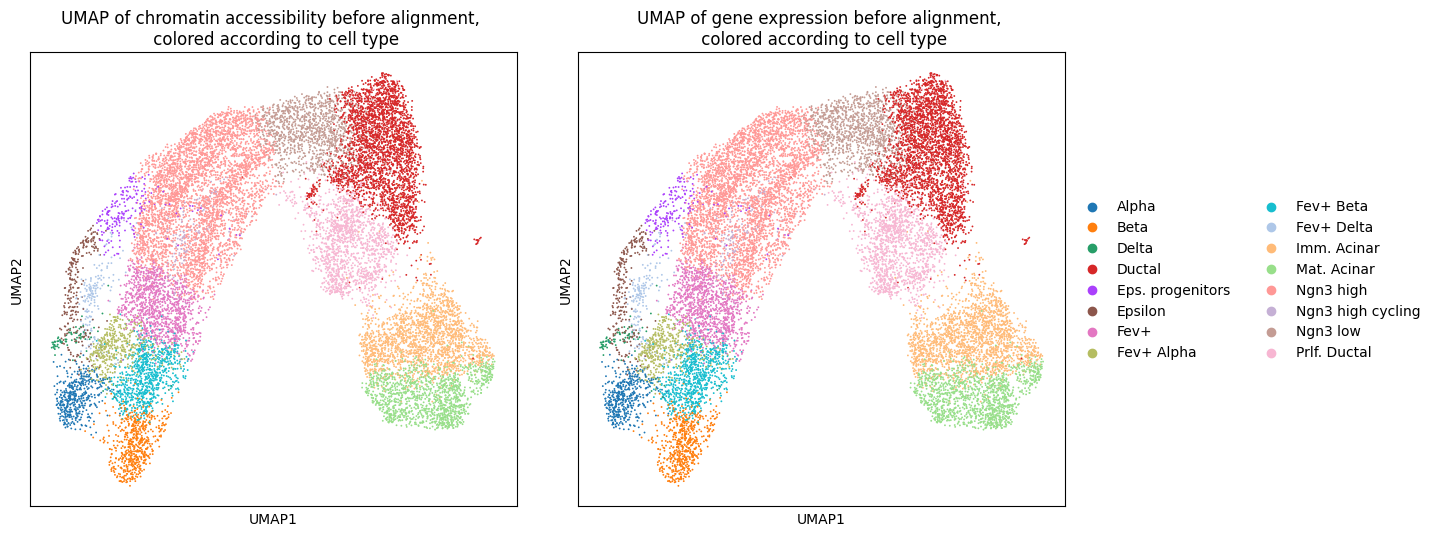

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="celltype", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="celltype", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

In [9]:
source = adata_atac.obsm["ATAC_lsi_l2_norm"]
target = adata_rna.obsm["X_pca"]

In [10]:
source_red = sc.pp.pca(source, n_comps=10)
target_red = sc.pp.pca(target, n_comps=10)

#source_concat = np.concatenate((sc.pp.pca(adata_atac.obsm["geneactivity_scvi"], n_comps=10), source_red), axis=-1)
#target_concat = np.concatenate((sc.pp.pca(adata_rna.obsm["geneactivity_scvi"], n_comps=10), target_red), axis=-1)

#source_concat = np.concatenate((adata_atac.obsm["geneactivity_scvi"], source_red), axis=-1)
#target_concat = np.concatenate((adata_rna.obsm["geneactivity_scvi"], target_red), axis=-1)

In [11]:
latent_embed_dim = 256
n_frequencies = 128
num_layers = 5

neural_net = MLP_vector_field(10, latent_embed_dim = 256, num_layers=8, n_frequencies=128)
#neural_net = MLP_fused_vector_field(10, 10, latent_embed_dim = 256, num_layers=num_layers, n_frequencies=128)
bridge_net = MLP_bridge(10, 10)
linear_ot_solver = sinkhorn.Sinkhorn(
                momentum=acceleration.Momentum(value=1., start=25)
        )
solver = ott.solvers.quadratic.gromov_wasserstein.GromovWasserstein(epsilon=1e-4, linear_ot_solver=linear_ot_solver)

otfm = OTFlowMatching(neural_net, bridge_net, epsilon=None, scale_cost="mean", input_dim=10, output_dim=10, iterations=50_000, ot_solver=solver, k_noise_per_x=1)

2023-09-07 17:26:59.460000: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:445] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-09-07 17:26:59.460098: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:449] Memory usage: 4521984 bytes free, 42338615296 bytes total.
2023-09-07 17:26:59.460205: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:459] Possibly insufficient driver version: 530.30.2


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
otfm(source_red, target_red, 1024, 1024)

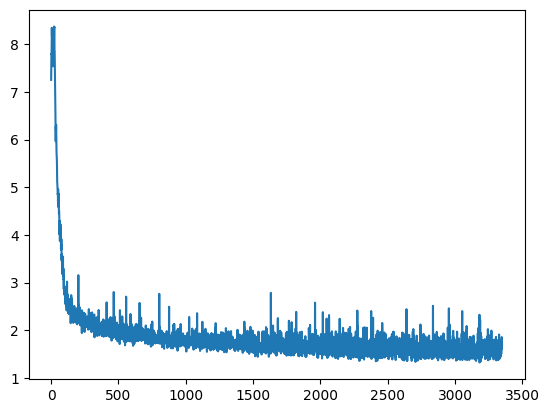

In [16]:
plt.plot(np.arange(len(otfm.metrics["loss"])), otfm.metrics["loss"])

In [19]:
gex_predicted,_,_ = otfm.transport(source_red, seed=0)

In [20]:
gex_predicted.shape, target_red.shape

((1, 6224, 20), (6224, 10))

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


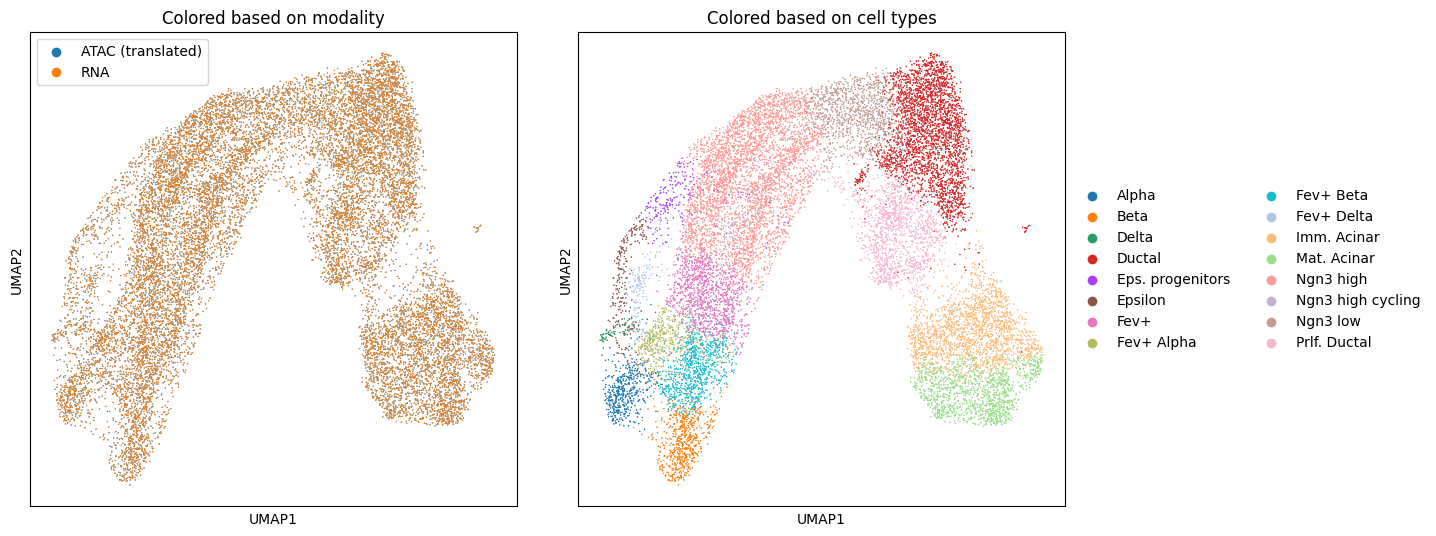

In [23]:
import scanpy as sc
bdata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
bdata.obsm["X_translated_1"] = np.concatenate(
    (gex_predicted[0,...], target_red), axis=0
)
sc.pp.neighbors(bdata, use_rep="X_translated_1")
sc.tl.umap(bdata)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(bdata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(bdata, color=["celltype"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

In [21]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

In [22]:
import scipy 
foscttm(gex_predicted[0,...], target_red)

0.606

In [89]:
foscttm(gex_predicted[0,...][..., 10:], target_concat[..., 10:])

0.4077

In [90]:
foscttm(gex_predicted[0,...][..., :10], target_concat[..., :10])

0.4552

array([[-0.02610219,  0.3724216 , -0.44630423, ...,  0.12265295,
        -0.04795334, -0.0345823 ],
       [-0.68083745, -0.14968407, -0.14959356, ..., -0.31034747,
         0.06349778, -0.12143186],
       [ 0.6386193 , -0.1296639 , -0.07507004, ...,  0.15760261,
        -0.04868598, -0.37897438],
       ...,
       [ 0.5997895 , -0.1712626 , -0.29415467, ...,  0.067004  ,
        -0.19914657, -0.20260626],
       [ 0.48882186,  0.12489576, -0.18914358, ..., -0.28019294,
        -0.3332797 ,  0.16555883],
       [ 0.46704817, -0.36587834, -0.04745301, ...,  0.35531285,
        -0.01991226, -0.162131  ]], dtype=float32)

In [91]:
res = [None] * 15

for i in range(15):
    res[i]= otfm.transport(source_concat, seed=i)[0][0,...]

In [92]:
gex_predicted = jnp.mean(jnp.asarray(res), axis=0)

In [93]:
foscttm(gex_predicted, target_concat)

0.398

In [94]:
foscttm(gex_predicted[..., 10:], target_concat[..., 10:])

0.3979

In [95]:
foscttm(gex_predicted[..., :10], target_concat[..., :10])

0.4295

In [93]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [94]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
adata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

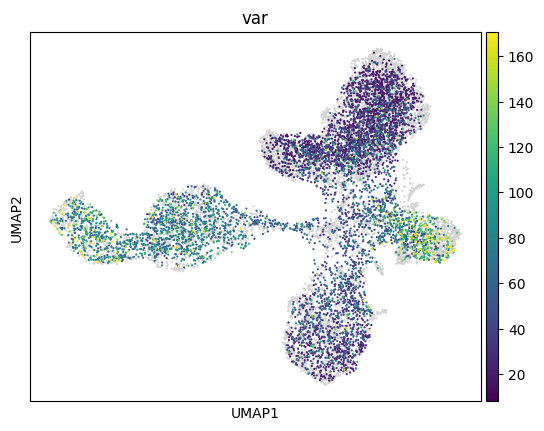

In [95]:
sc.pl.umap(adata, color="var", vmax="p99")

In [96]:
adata.obs[["cell_type", "var"]].groupby("cell_type").mean()

,var
cell_type,
B1 B,54.872770
CD4+ T activated,21.465642
CD4+ T naive,23.234807
CD8+ T,39.050158
CD14+ Mono,38.559134
CD16+ Mono,39.792966
Erythroblast,65.882338
G/M prog,53.491265
HSC,56.533601


In [33]:
sc.tl.dendrogram(adata, groupby="cell_type")

         Falling back to preprocessing with `sc.pp.pca` and default params.


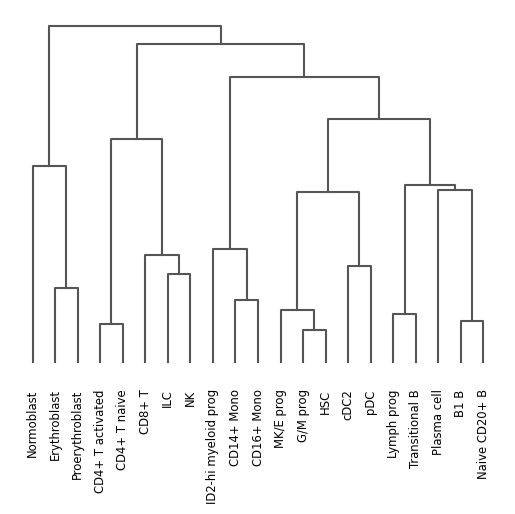

<Axes: >

In [35]:
sc.pl.dendrogram(adata, groupby="cell_type")

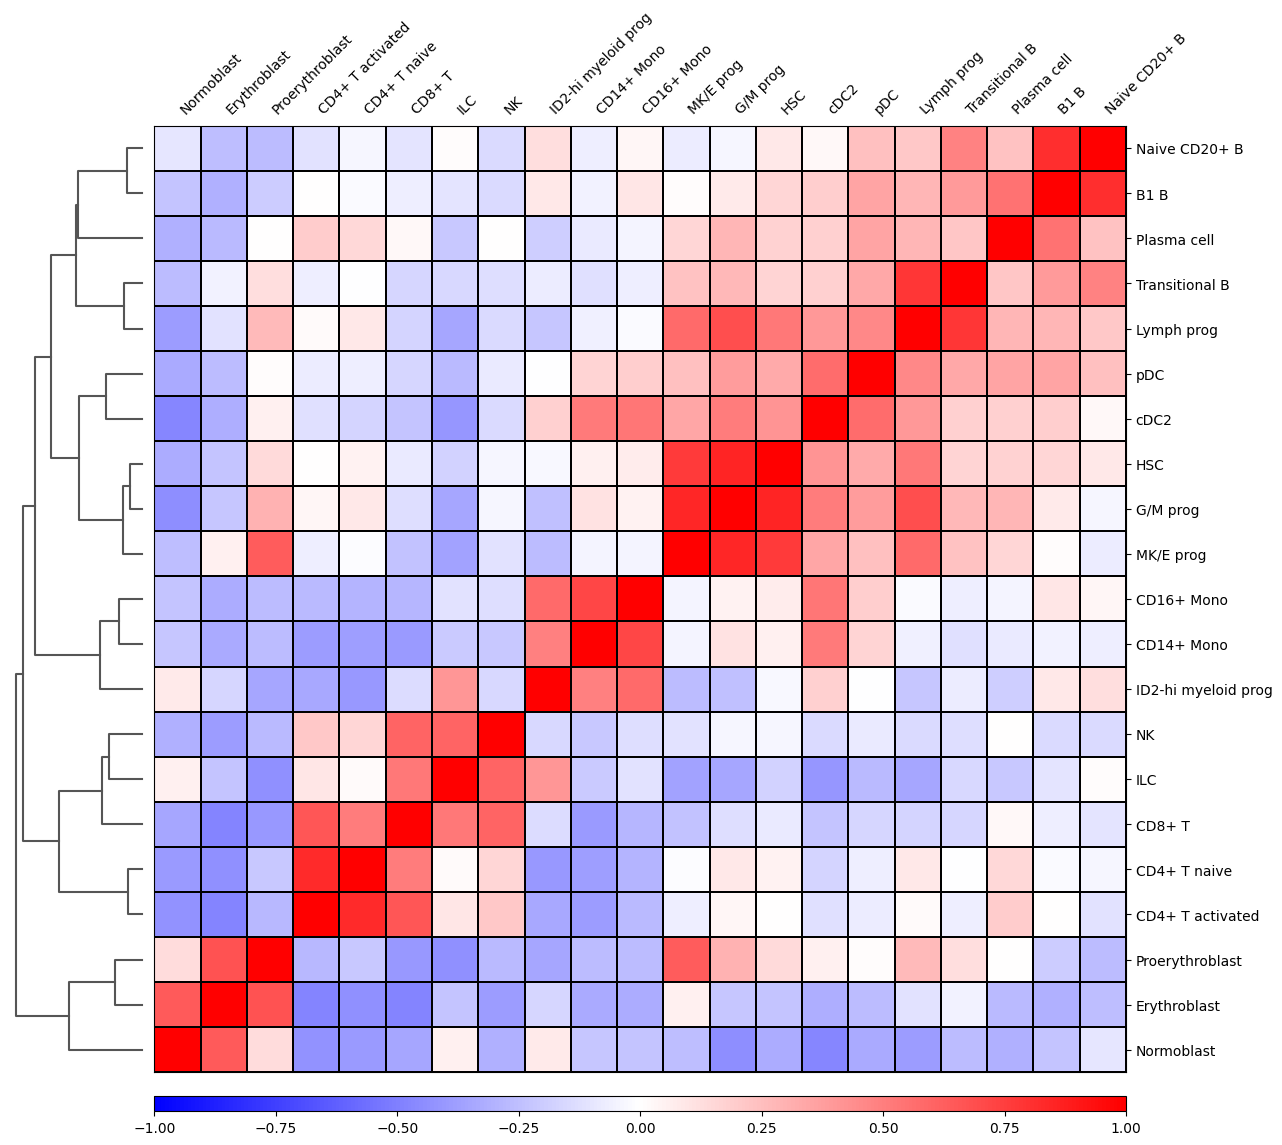

In [37]:
sc.pl.correlation_matrix(adata, groupby="cell_type")